# Umsetzung Q-Agent mit Ideen aus Paper von Vos und Sabatelli
3 verschiedene Exploaration Policies:
- greedy
- e-greedy
- softmax


Hyperparameter:
- learning rate (alpha) = 0,4
- discount factor (gamma) = 0,9
- epochs = 1 Mio
- epsilon = 0,05 (gibt Variante mit epsilon decay bis e = 0, wobei e = e - E/Anzahl Epochen)


Rewards:
- Verlieren = -0,5
- Gewinnen = 4
- Hit ohne bust = 2
Es werden jeweils 50 Agenten trainiert und das Ergebnis gemittelt

In [19]:
from blackjackenv import BlackjackEnv
from qagent import QAgent
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

In [20]:
# hyperparameters
learning_rate = 0.001
n_episodes = 100_000 # nach Vos 1_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0
gamma = 0.95

def initiate_agents(number_of_agents, exp_policy, learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma):
    agents = []
    
    for i in range(0,number_of_agents):
        agent = QAgent(
            exp_policy=exp_policy,
            alpha=learning_rate,
            initial_epsilon=start_epsilon,
            epsilon_decay=epsilon_decay,
            final_epsilon=final_epsilon,
            gamma=gamma
        )
        agents.append(agent)
    return agents

In [21]:
softmax_agents = initiate_agents(50, "softmax", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [22]:
greedy_agents = initiate_agents(50, "greedy", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [23]:
e_greedy_agents = initiate_agents(50, "e_greedy", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [24]:
def train_agents(agents):
    envs = []
    for agent in agents:
        env = BlackjackEnv(sab=True, win_reward=1.0, lose_reward=-1.0, hit_reward=0.1)
        env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
        for episode in tqdm(range(n_episodes)):
            state, info = env.reset()
            done = False
    
            # play one episode
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
    
                # update the agent
                agent.update(state, action, reward, terminated, next_state)
    
                # update if the environment is done and the current obs
                done = terminated or truncated
                state = next_state
    
            agent.decay_epsilon()
        envs.append(env)
    return envs

In [26]:
envs_softmax = train_agents(softmax_agents)
envs_greedy = train_agents(greedy_agents)
envs_e_greedy = train_agents(e_greedy_agents)


100%|██████████| 100000/100000 [00:55<00:00, 1795.75it/s][A

100%|██████████| 100000/100000 [00:56<00:00, 1777.04it/s][A

100%|██████████| 100000/100000 [00:55<00:00, 1815.01it/s][A

 56%|█████▋    | 56302/100000 [00:30<00:27, 1592.39it/s]

KeyboardInterrupt: 

In [25]:
def calculate_avg_reward(envs, rolling_length):
    rolling_length = rolling_length
    avg = []
    for env in envs:
        reward_average = (
            np.convolve(
                np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        avg.append(reward_average)
    
    avg_50_agents_100_games = []
    for i in range(len(avg[0])):
        a = []
        for j in range(len(avg)):
            m = avg[j][i]
            a.append(m)
        avg_50_agents_100_games.append(np.mean(a))
    
    return avg_50_agents_100_games

In [87]:
softmax_rewards = calculate_avg_reward(envs_softmax, 10_000)
greedy_rewards = calculate_avg_reward(envs_greedy, 10_000)
e_greedy_rewards = calculate_avg_reward(envs_e_greedy, 10_000)

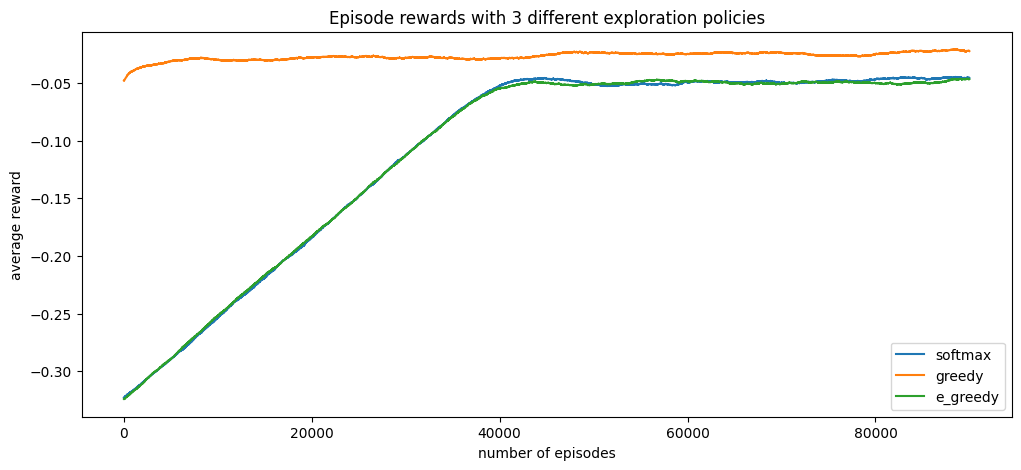

In [88]:
fig, axs = plt.subplots(figsize=(12, 5))
axs.set_title("Episode rewards with 3 different exploration policies")
axs.plot(range(len(softmax_rewards)), softmax_rewards, label = "softmax")
axs.plot(range(len(greedy_rewards)), greedy_rewards, label = "greedy")
axs.plot(range(len(e_greedy_rewards)), e_greedy_rewards, label = "e_greedy")
plt.legend()
plt.xlabel("number of episodes")
plt.ylabel("average reward")
plt.show()

In [89]:
a = [e_greedy_agents, greedy_agents, softmax_agents]
wins = []
for agents in a:
    env = BlackjackEnv(sab=True, win_reward=1.0, lose_reward=-1.0, hit_reward=0.1)
    random_agents = np.random.choice(agents, size=3)
    for random_agent in random_agents:
        agent = random_agent
        win = 0
        for episode in tqdm(range(n_episodes)):
            state, info = env.reset()
            done = False
        
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
            
                done = terminated or truncated
                state = next_state
                if reward >= 1.0:
                    win += 1
        wins.append(win)


100%|██████████| 100000/100000 [00:03<00:00, 25394.62it/s][A

100%|██████████| 100000/100000 [00:03<00:00, 25889.83it/s][A

100%|██████████| 100000/100000 [00:03<00:00, 26154.82it/s][A

100%|██████████| 100000/100000 [00:03<00:00, 26371.12it/s][A

100%|██████████| 100000/100000 [00:03<00:00, 25978.56it/s][A

100%|██████████| 100000/100000 [00:03<00:00, 26382.78it/s][A

100%|██████████| 100000/100000 [00:04<00:00, 22893.61it/s][A

100%|██████████| 100000/100000 [00:04<00:00, 22864.09it/s][A

100%|██████████| 100000/100000 [00:04<00:00, 22942.27it/s][A


In [90]:
policies = ["e_greedy", "greedy", "softmax"]
for i in range(0,9,3):
    policy = policies[int(i/3)]
    sum = 0
    for j in range(i,3+i):
        sum = sum + (wins[j]/n_episodes)
    avg = sum/3
    print("{} : {}%".format(policy,avg*100))

e_greedy : 0.4117166666666667%
greedy : 0.42099666666666663%
softmax : 0.40785999999999994%


## Verschiedene Rewards ausprobieren

### Hit Rewards testen

In [22]:
learning_rate = 0.001
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2) 
final_epsilon = 0.1
discount_factor = 0.95

agent = QAgent(
    exp_policy="e_greedy",
    alpha=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma=discount_factor
)

reward_envs = []

for i in range(0,10):
    j = 0.1
    j = j + 0.1
    env = BlackjackEnv(sab=True, win_reward=1.0, lose_reward=-1.0, hit_reward=j)
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update the agent
            agent.update(state, action, reward, terminated, next_state)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state

        agent.decay_epsilon()
    reward_envs.append(env)


100%|██████████| 100000/100000 [00:06<00:00, 14340.79it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14145.43it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14097.17it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14139.07it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14162.59it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14209.06it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14131.73it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14064.55it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14066.31it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14065.13it/s][A


In [23]:
wins = []
for env in reward_envs:
    
    win = 0
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state
            if reward == 1:
                win += 1

    wins.append(win / n_episodes)


100%|██████████| 100000/100000 [00:06<00:00, 14811.76it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14935.13it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14895.35it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14882.32it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14993.67it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 15019.18it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 15014.06it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14965.82it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14966.02it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14916.30it/s][A


Text(0.5, 1.0, 'Changing hit reward')

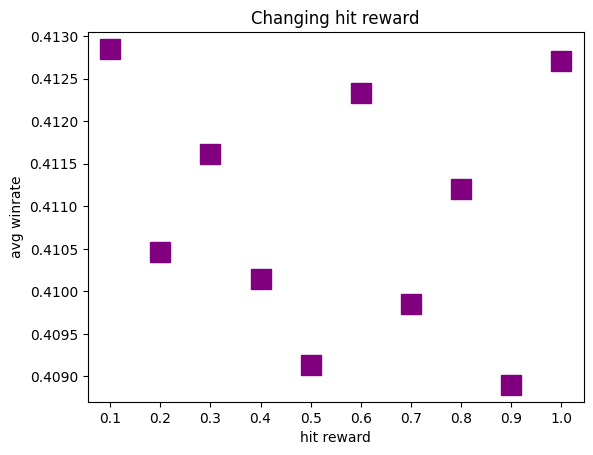

In [44]:
labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.plot(labels, wins, 's', c="purple", markersize=15)
plt.xticks(labels)
plt.xlabel("hit reward")
plt.ylabel("avg winrate")
plt.title("Changing hit reward")

### Win Rewards testen (1.0 bis 10.0)

In [53]:
win_reward_envs = []

for i in range(0,10):
    j = 1.0
    j = j + 1.0
    env = BlackjackEnv(sab=True, win_reward=j, lose_reward=-1.0, hit_reward=0.0)
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update the agent
            agent.update(state, action, reward, terminated, next_state)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state

        agent.decay_epsilon()
    win_reward_envs.append(env)


100%|██████████| 100000/100000 [00:07<00:00, 13910.50it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 13980.72it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 13095.41it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14015.27it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14158.96it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14079.70it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14022.61it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14047.34it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14061.61it/s][A

100%|██████████| 100000/100000 [00:07<00:00, 14143.60it/s][A


In [54]:
w_wins = []
l = range(1,11)
for env in win_reward_envs:
    i = 0
    win = 0
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state
            if reward == l[i]:
                win += 1
    i = i+1
    w_wins.append(win / n_episodes)


100%|██████████| 100000/100000 [00:06<00:00, 14762.29it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14995.45it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14978.19it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14883.04it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14642.61it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14946.24it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14821.08it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14923.94it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14858.93it/s][A

100%|██████████| 100000/100000 [00:06<00:00, 14899.19it/s][A


Text(0.5, 1.0, 'Changing win reward')

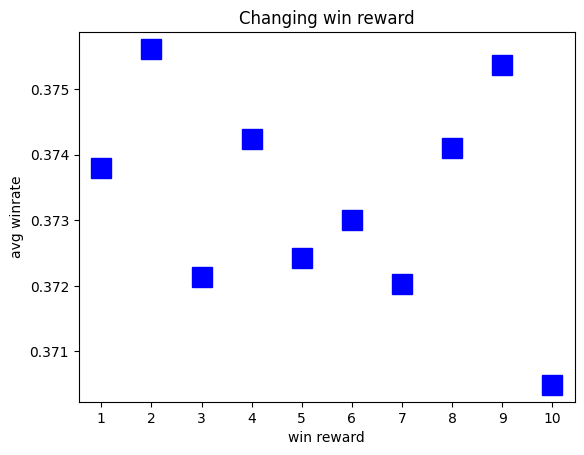

In [55]:
plt.plot(l, w_wins, 's', c="blue", markersize=15)
plt.xticks(l)
plt.xlabel("win reward")
plt.ylabel("avg winrate")
plt.title("Changing win reward")

## Hit und Win Rewards

In [56]:
hits = [0.0, 0.1, 0.3, 0.6, 0.8, 1.0]
w = [1.0, 1.5, 2.0]

hit_win_reward_envs = []

for hit in hits:
    for win in w:
        print(hit)
        print(win)
        env = BlackjackEnv(sab=True, win_reward=win, lose_reward=-1.0, hit_reward=hit)
        env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
        for episode in tqdm(range(10_000)):
            state, info = env.reset()
            done = False

            # play one episode
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)

                # update the agent
                agent.update(state, action, reward, terminated, next_state)

                # update if the environment is done and the current obs
                done = terminated or truncated
                state = next_state

            agent.decay_epsilon()
        hit_win_reward_envs.append(env)


 12%|█▏        | 1190/10000 [00:00<00:00, 11889.78it/s]

0.0
1.0



100%|██████████| 10000/10000 [00:00<00:00, 13277.95it/s][A

 13%|█▎        | 1343/10000 [00:00<00:00, 13423.68it/s]


0.0
1.5


100%|██████████| 10000/10000 [00:00<00:00, 13580.27it/s][A

 13%|█▎        | 1342/10000 [00:00<00:00, 13413.01it/s]


0.0
2.0


100%|██████████| 10000/10000 [00:00<00:00, 13858.47it/s][A

 14%|█▍        | 1395/10000 [00:00<00:00, 13945.26it/s]


0.1
1.0


100%|██████████| 10000/10000 [00:00<00:00, 13887.42it/s][A

 13%|█▎        | 1333/10000 [00:00<00:00, 13329.09it/s]


0.1
1.5


100%|██████████| 10000/10000 [00:00<00:00, 13894.53it/s][A

 13%|█▎        | 1349/10000 [00:00<00:00, 13484.48it/s]


0.1
2.0


100%|██████████| 10000/10000 [00:00<00:00, 13815.25it/s][A

 14%|█▍        | 1400/10000 [00:00<00:00, 13992.27it/s]


0.3
1.0


100%|██████████| 10000/10000 [00:00<00:00, 14051.12it/s][A

 13%|█▎        | 1337/10000 [00:00<00:00, 13369.34it/s]


0.3
1.5


100%|██████████| 10000/10000 [00:00<00:00, 13894.91it/s][A

 14%|█▎        | 1358/10000 [00:00<00:00, 13578.49it/s]


0.3
2.0


100%|██████████| 10000/10000 [00:00<00:00, 13873.63it/s][A

 14%|█▍        | 1437/10000 [00:00<00:00, 14360.05it/s]


0.6
1.0


100%|██████████| 10000/10000 [00:00<00:00, 13906.73it/s][A

 14%|█▍        | 1399/10000 [00:00<00:00, 13982.71it/s]


0.6
1.5


100%|██████████| 10000/10000 [00:00<00:00, 13841.84it/s][A

 14%|█▍        | 1447/10000 [00:00<00:00, 14463.81it/s]


0.6
2.0


100%|██████████| 10000/10000 [00:00<00:00, 13897.38it/s][A

 14%|█▎        | 1355/10000 [00:00<00:00, 13542.94it/s]


0.8
1.0


100%|██████████| 10000/10000 [00:00<00:00, 13863.85it/s][A

 14%|█▍        | 1441/10000 [00:00<00:00, 14406.82it/s]


0.8
1.5


100%|██████████| 10000/10000 [00:00<00:00, 13971.67it/s][A

 13%|█▎        | 1347/10000 [00:00<00:00, 13463.14it/s]

0.8
2.0



100%|██████████| 10000/10000 [00:00<00:00, 13899.00it/s][A

 14%|█▍        | 1405/10000 [00:00<00:00, 14038.77it/s]


1.0
1.0


100%|██████████| 10000/10000 [00:00<00:00, 13840.28it/s][A

 14%|█▍        | 1389/10000 [00:00<00:00, 13884.15it/s]


1.0
1.5


100%|██████████| 10000/10000 [00:00<00:00, 13801.23it/s][A

 13%|█▎        | 1340/10000 [00:00<00:00, 13392.76it/s]


1.0
2.0


100%|██████████| 10000/10000 [00:00<00:00, 13667.04it/s][A


In [57]:
#hits = [0.0, 0.1, 0.3, 0.6, 0.8, 1.0]
lab_w = [1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 2.0, 2.0, 2.0]

hit_win_wins = []
for env in hit_win_reward_envs:
    i = 0
    win = 0
    for episode in tqdm(range(10_000)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state
            if reward == lab_w[i]:
                win += 1
    i = i+1
    hit_win_wins.append(win / 10_000)


100%|██████████| 10000/10000 [00:00<00:00, 14437.45it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14810.99it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14854.80it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14885.27it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14583.68it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14760.58it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14891.32it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14653.39it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14962.15it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14804.38it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14893.61it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14880.26it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14999.25it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14822.98it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14791.65it/s][A

100%|██████████| 10000/10000 [00:00<00:00, 14834.53it/s][A

100%|██████████| 10000/10000 [00:00<00:

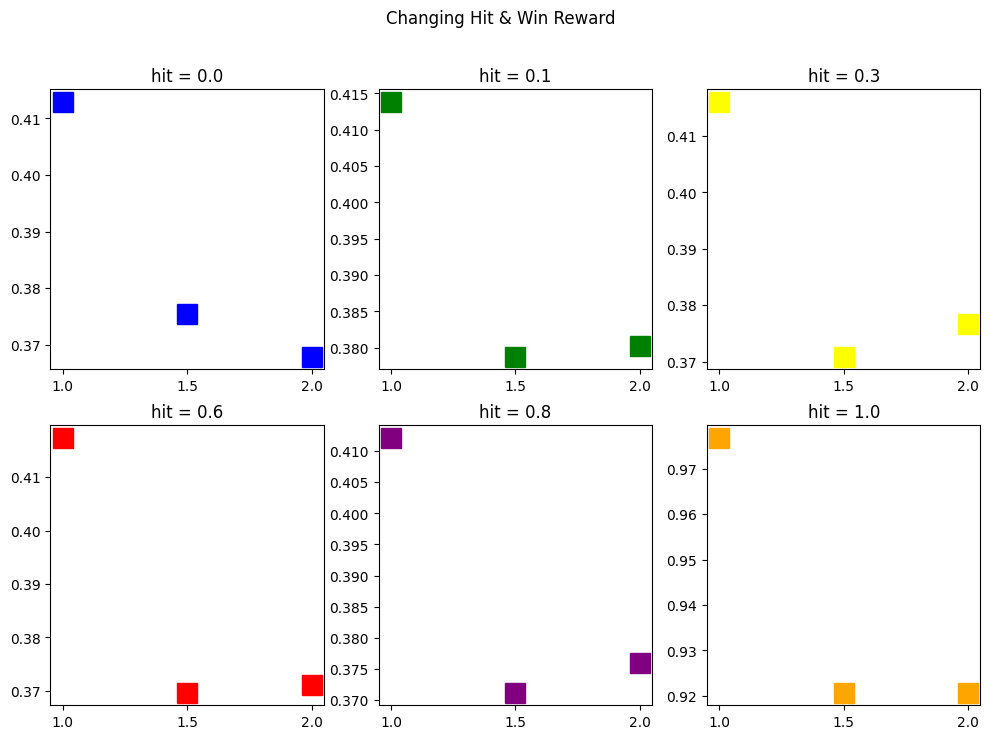

In [79]:
#hits = [0.0, 0.1, 0.3, 0.6, 0.8, 1.0]
#win = [1.0, 1.5, 2.0]

fig,ax = plt.subplots(ncols=3, nrows=2, figsize=(12,8))
fig.suptitle("Changing Hit & Win Reward")

ax[0][0].set_title("hit = 0.0")
ax[0][0].set_xticks([1.0, 1.5, 2.0])
ax[0][0].plot([1.0, 1.5, 2.0], hit_win_wins[:3], 's', c="blue", markersize=15)
ax[0][1].set_xticks([1.0, 1.5, 2.0])
ax[0][1].set_title("hit = 0.1")
ax[0][1].plot([1.0, 1.5, 2.0], hit_win_wins[3:6], 's', c="green", markersize=15)
ax[0][2].set_xticks([1.0, 1.5, 2.0])
ax[0][2].set_title("hit = 0.3")
ax[0][2].plot([1.0, 1.5, 2.0], hit_win_wins[6:9], 's', c="yellow", markersize=15)
ax[1][0].set_xticks([1.0, 1.5, 2.0])
ax[1][0].set_title("hit = 0.6")
ax[1][0].plot([1.0, 1.5, 2.0], hit_win_wins[9:12], 's', c="red", markersize=15)
ax[1][1].set_xticks([1.0, 1.5, 2.0])
ax[1][1].set_title("hit = 0.8")
ax[1][1].plot([1.0, 1.5, 2.0], hit_win_wins[12:15], 's', c="purple", markersize=15)
ax[1][2].set_xticks([1.0, 1.5, 2.0])
ax[1][2].set_title("hit = 1.0")
ax[1][2].plot([1.0, 1.5, 2.0], hit_win_wins[15:], 's', c="orange", markersize=15)